<a href="https://colab.research.google.com/github/scw1998/projects/blob/main/UOS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### NAME: 서치원
### revision (1) : Seongjun Lee

## Introduction
The dataset spans from January 1, 2018, to December 31, 2021, and includes daily rental data for four districts:<br> 
Gwangjin-gu, Dongdaemun-gu, Seongdong-gu, and Jungnang-gu. Each district's data is recorded in thousands of rentals per day. I will use LSTM

## Revision
1. I could develop from naive LSTM to Seq2Seq LSTM with precipitation data in Seoul
    - this dataset from Meteorological Administration([link](https://data.kma.go.kr/climate/RankState/selectRankStatisticsDivisionList.do))
2. change from one step prediction to n-step prediction
3. not use scaler, if you use right way then can get more less score than before


In [1]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error


/home/sjlee/miniconda3/envs/sj_virtual/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Load the data
data = pd.read_csv("train.csv")

# Convert the date column to datetime format
data['일시'] = pd.to_datetime(data['일시'], format='%Y%m%d')

# Set the date column as the index
data.set_index('일시', inplace=True)

#Rename the column names
data.index.names = ['Date']
data.columns = ["Gwang","Dong",'Sung',"Joong"] #광진구	동대문구	성동구	중랑구

data

,Gwang,Dong,Sung,Joong
Date,,,,
2018-01-01,0.592,0.368,0.580,0.162
2018-01-02,0.840,0.614,1.034,0.260
2018-01-03,0.828,0.576,0.952,0.288
2018-01-04,0.792,0.542,0.914,0.292
2018-01-05,0.818,0.602,0.994,0.308
...,...,...,...,...
2021-12-27,3.830,3.416,2.908,2.350
2021-12-28,4.510,3.890,3.714,2.700
2021-12-29,4.490,3.524,3.660,2.524


In [3]:
data.describe()

,Gwang,Dong,Sung,Joong
count,1461.000000,1461.000000,1461.000000,1461.000000
mean,6.209194,4.233670,5.182951,3.138747
std,3.531408,2.695602,2.937556,2.046930
min,0.000000,0.000000,0.000000,0.000000
25%,3.256000,2.068000,2.676000,1.456000
50%,5.740000,3.588000,4.850000,2.596000
75%,9.444000,6.212000,7.704000,4.768000
max,15.184000,11.708000,13.366000,8.028000


In [4]:
rainy = pd.read_csv('./rainy.csv')
rainy = rainy.loc[:,'강수량(mm)']
rainy.fillna(0,inplace = True) # Na is sunny day
rainy

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1456    0.0
1457    0.0
1458    0.2
1459    0.0
1460    0.0
Name: 강수량(mm), Length: 1461, dtype: float64

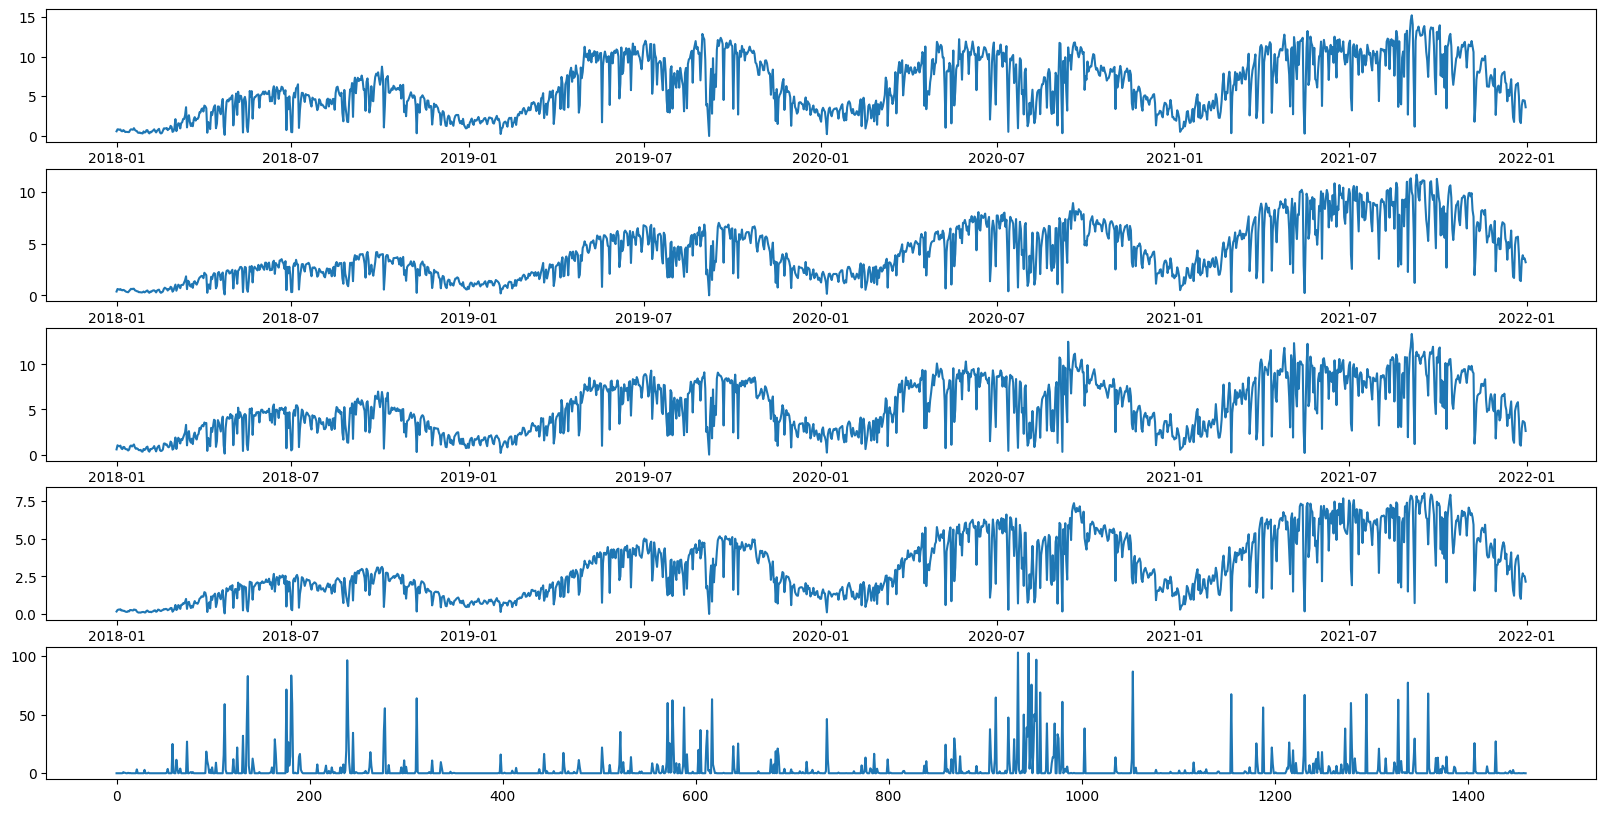

In [5]:
fig,axes = plt.subplots(5,1, figsize = (20,10))
axes[0].plot(data.iloc[:,0])
axes[1].plot(data.iloc[:,1])
axes[2].plot(data.iloc[:,2])
axes[3].plot(data.iloc[:,3])
axes[4].plot(rainy)

In [6]:
data.loc[:,'rainy'] = rainy.values
data

,Gwang,Dong,Sung,Joong,rainy
Date,,,,,
2018-01-01,0.592,0.368,0.580,0.162,0.0
2018-01-02,0.840,0.614,1.034,0.260,0.0
2018-01-03,0.828,0.576,0.952,0.288,0.0
2018-01-04,0.792,0.542,0.914,0.292,0.0
2018-01-05,0.818,0.602,0.994,0.308,0.0
...,...,...,...,...,...
2021-12-27,3.830,3.416,2.908,2.350,0.0
2021-12-28,4.510,3.890,3.714,2.700,0.0
2021-12-29,4.490,3.524,3.660,2.524,0.2


In [7]:
data.describe()

,Gwang,Dong,Sung,Joong,rainy
count,1461.000000,1461.000000,1461.000000,1461.000000,1461.000000
mean,6.209194,4.233670,5.182951,3.138747,3.431211
std,3.531408,2.695602,2.937556,2.046930,11.617738
min,0.000000,0.000000,0.000000,0.000000,0.000000
25%,3.256000,2.068000,2.676000,1.456000,0.000000
50%,5.740000,3.588000,4.850000,2.596000,0.000000
75%,9.444000,6.212000,7.704000,4.768000,0.300000
max,15.184000,11.708000,13.366000,8.028000,103.100000


In [8]:
# Normalize the data
## I don't know why you use MinMaxScale?
## and this must use each feature individually.
# scaler = MinMaxScaler()
# scaled_data = scaler.fit_transform(data)
# scaled_data

In [9]:
# Transform the time series data into a suitable format for training the LSTM model
def create_sequences(data, seq_length, pred_len):
    x_seq, y_seq, exog = [], [], []
    for i in range(len(data) - (seq_length+pred_len-1)):
        x = data[i:i+seq_length]
        y = data[i+seq_length:i+seq_length+pred_len,:-1]
        z = data[i+seq_length:i+seq_length+pred_len,-1]
        #print(x,"->",y)
        x_seq.append(x)
        y_seq.append(y)
        exog.append(z)
    return np.array(x_seq), np.array(y_seq), np.array(exog)

In [10]:
data

,Gwang,Dong,Sung,Joong,rainy
Date,,,,,
2018-01-01,0.592,0.368,0.580,0.162,0.0
2018-01-02,0.840,0.614,1.034,0.260,0.0
2018-01-03,0.828,0.576,0.952,0.288,0.0
2018-01-04,0.792,0.542,0.914,0.292,0.0
2018-01-05,0.818,0.602,0.994,0.308,0.0
...,...,...,...,...,...
2021-12-27,3.830,3.416,2.908,2.350,0.0
2021-12-28,4.510,3.890,3.714,2.700,0.0
2021-12-29,4.490,3.524,3.660,2.524,0.2


In [11]:
# Split the data into training and testing sets
split_ratio = 0.8
train_size = int(len(data) * split_ratio)
train_data = data[:train_size].values
test_data = data[train_size:].values


In [12]:
# Define sequence length
seq_length = 30
pred_length = 7 # forecast one week

# Create sequences
X_train, y_train, exog_train = create_sequences(train_data, seq_length,pred_length)
X_test, y_test, exog_test = create_sequences(test_data, seq_length,pred_length)
print(X_train.shape, y_train.shape, exog_train.shape)

(1132, 30, 5) (1132, 7, 4) (1132, 7)


In [13]:
from typing import Any


class custom_dataset(TensorDataset):
    def __init__(self,x,y,z):
        super().__init__()
        self.x = x
        self.y = y
        self.z = z
    def __len__(self):
        return len(self.x)
    def __getitem__(self, index: Any):
        x = self.x[index]
        y = self.y[index]
        z = self.z[index]
        return_dict = {
            'input':x,
            'target':y,
            'exog':z
        }
        return return_dict


In [14]:
# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
exog_train = torch.FloatTensor(exog_train).unsqueeze(2)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)
exog_test = torch.FloatTensor(exog_test).unsqueeze(2)

# Create DataLoader for batch processing
train_dataset = custom_dataset(X_train, y_train, exog_train)
test_dataset = custom_dataset(X_test, y_test, exog_test)

In [15]:
train_dataset[0].keys()

dict_keys(['input', 'target', 'exog'])

In [16]:
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Display the shapes of the datasets
print(next(iter(train_loader))['input'].size()) # input data size
print(next(iter(train_loader))['target'].size()) # target data size
print(next(iter(train_loader))['exog'].size()) # target data size

torch.Size([32, 30, 5])
torch.Size([32, 7, 4])
torch.Size([32, 7, 1])


In [17]:
# Define the LSTM model (Extension of RNN)
# make seq2seq model 
class LSTM(nn.Module):
    def __init__(self,
                input_size,
                hidden_size,
                exog_size,
                num_layers,
                output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
        self.encoder = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.decoder = nn.LSTM(exog_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, exog=None):
        # when train
        if type(x)==dict:
            input = x['input'].to(self.device)
            exog = x['exog'].to(self.device)
        else: # when real 
            input = x.to(self.device)
            exog = exog

        h0 = torch.zeros((self.num_layers, input.size(0), self.hidden_size)).to(self.device)
        c0 = torch.zeros((self.num_layers, input.size(0), self.hidden_size)).to(self.device) # RNN으로 하고 싶으시면, 이 line지우시면 됩니다.
        context, state = self.encoder(input, (h0,c0))
        out,_ = self.decoder(exog,state)
        out = self.fc(out)
        return out

In [18]:
# Set device, hyperparameters, and initialize the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'{device} is available')

cuda is available


In [19]:
input_size = X_train.shape[2] #4
output_size = y_train.shape[2] #7
hidden_size = 64
exog_size = 1
num_layers = 2
num_epochs = 200
learning_rate = 0.001

In [20]:
model = LSTM(input_size, hidden_size, exog_size, num_layers, output_size).to(device)
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [21]:
loss_graph = []
# Train the model
model.train() # Set the model to training mode
for epoch in range(num_epochs):
  running_loss = 0.0 # Initialize running loss for the current epoch
  for i in train_loader:
    x = {
      'input':i['input'],
      'exog':i['exog']
    }
    target = i['target'].to(device)
    out = model(x)
    loss = criterion(out,target)
    optimizer.zero_grad() # Clear the gradients of all optimized tensors
    loss.backward() # compute gradient of the loss with respect to model parameters
    optimizer.step()  #Perform a single optimization step
    running_loss += loss.item()
  loss_graph.append(running_loss / len(train_loader))
  if (epoch + 1) % 10 == 0: # Print the loss every 10 epochs
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}') # Print the current epoch and loss


Epoch [10/200], Loss: 1.2793
Epoch [20/200], Loss: 0.9801
Epoch [30/200], Loss: 0.7455
Epoch [40/200], Loss: 0.6645
Epoch [50/200], Loss: 0.6353
Epoch [60/200], Loss: 0.7279
Epoch [70/200], Loss: 0.5683
Epoch [80/200], Loss: 0.9700
Epoch [90/200], Loss: 0.3876
Epoch [100/200], Loss: 0.5477
Epoch [110/200], Loss: 0.3898
Epoch [120/200], Loss: 0.6470
Epoch [130/200], Loss: 0.3354
Epoch [140/200], Loss: 0.3442
Epoch [150/200], Loss: 0.3154
Epoch [160/200], Loss: 0.4027
Epoch [170/200], Loss: 0.2885
Epoch [180/200], Loss: 0.4425
Epoch [190/200], Loss: 0.2585
Epoch [200/200], Loss: 0.2813


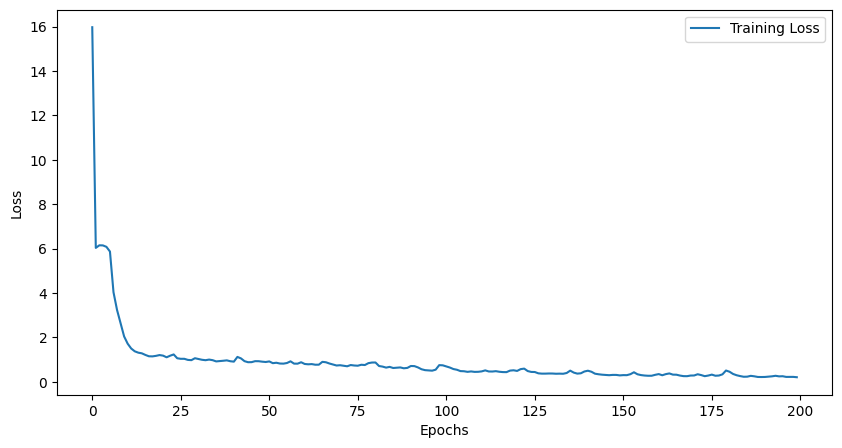

In [22]:
# Plot the loss graph
plt.figure(figsize=(10, 5))
plt.plot(range(num_epochs), loss_graph, label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
X_train.size()

torch.Size([1132, 30, 5])

In [24]:
# Evaluate the model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    train_predictions = model(X_train.to(device),exog_train.to(device)).cpu().numpy()
    test_predictions = model(X_test.to(device),exog_test.to(device)).cpu().numpy()

In [25]:
train_predictions.shape

(1132, 7, 4)

In [26]:
test_predictions = test_predictions.reshape(-1,test_predictions.shape[2])
y_test = y_test.numpy().reshape(-1,y_test.size(2))
print(test_predictions.shape,y_test.shape)

(1799, 4) (1799, 4)


In [27]:
# Calculate RMSE Lower the RMSE, the lower, the better
test_rmse = np.sqrt(mean_squared_error(y_test, test_predictions))

In [28]:
# Calculate NMAPE, the lower, the better
def nmape(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / (np.max(y_true) - np.min(y_true)))) * 100
def smape(y_true,y_pred):
    return np.mean(np.abs((y_true - y_pred) / (y_true - y_pred)/2)) * (100/len(y_true))

test_nmape = nmape(y_test, test_predictions)
test_smape = smape(y_test, test_predictions)

print(f'Test RMSE: {test_rmse:.4f}, Test NMAPE: {test_nmape}, Test SMAPE: {test_smape}')

Test RMSE: 2.2231, Test NMAPE: 11.962750554084778, Test SMAPE: 0.027793218454697052


**이전 성능**<br>
Train RMSE: 1.0893, Train NMAPE: 5.753983295519531<br>
Test RMSE: 2.4476, Test NMAPE: 11.835296902209127<br>
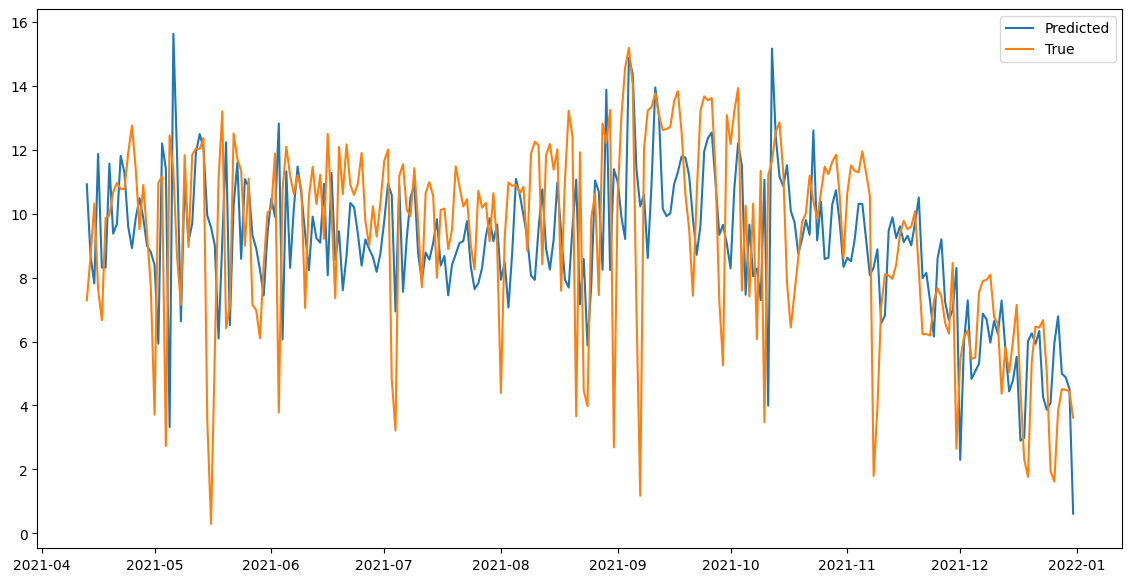

In [29]:
# Forecasting future values
future_steps = 30  # Number of days to forecast
last_sequence = X_test[-1].unsqueeze(0).to(device)
last_exog = exog_test[-1].unsqueeze(0).to(device)
future_predictions = []

model.eval()

with torch.no_grad():
    future_pred = model(last_sequence,last_exog)
print(future_pred)

tensor([[[4.6820, 4.0112, 4.1535, 3.0126],
         [4.4370, 3.7619, 3.8915, 2.8242],
         [4.4624, 3.7803, 3.9091, 2.8254],
         [4.6954, 3.9478, 4.1264, 2.9420],
         [4.4108, 3.7327, 3.8693, 2.7708],
         [4.7084, 3.9147, 4.1528, 2.8967],
         [5.0200, 4.1063, 4.4276, 3.0340]]], device='cuda:0')


In [30]:
future_predictions = future_pred.to('cpu').squeeze(0).numpy()

In [31]:
y_test = y_test[-pred_length:]

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


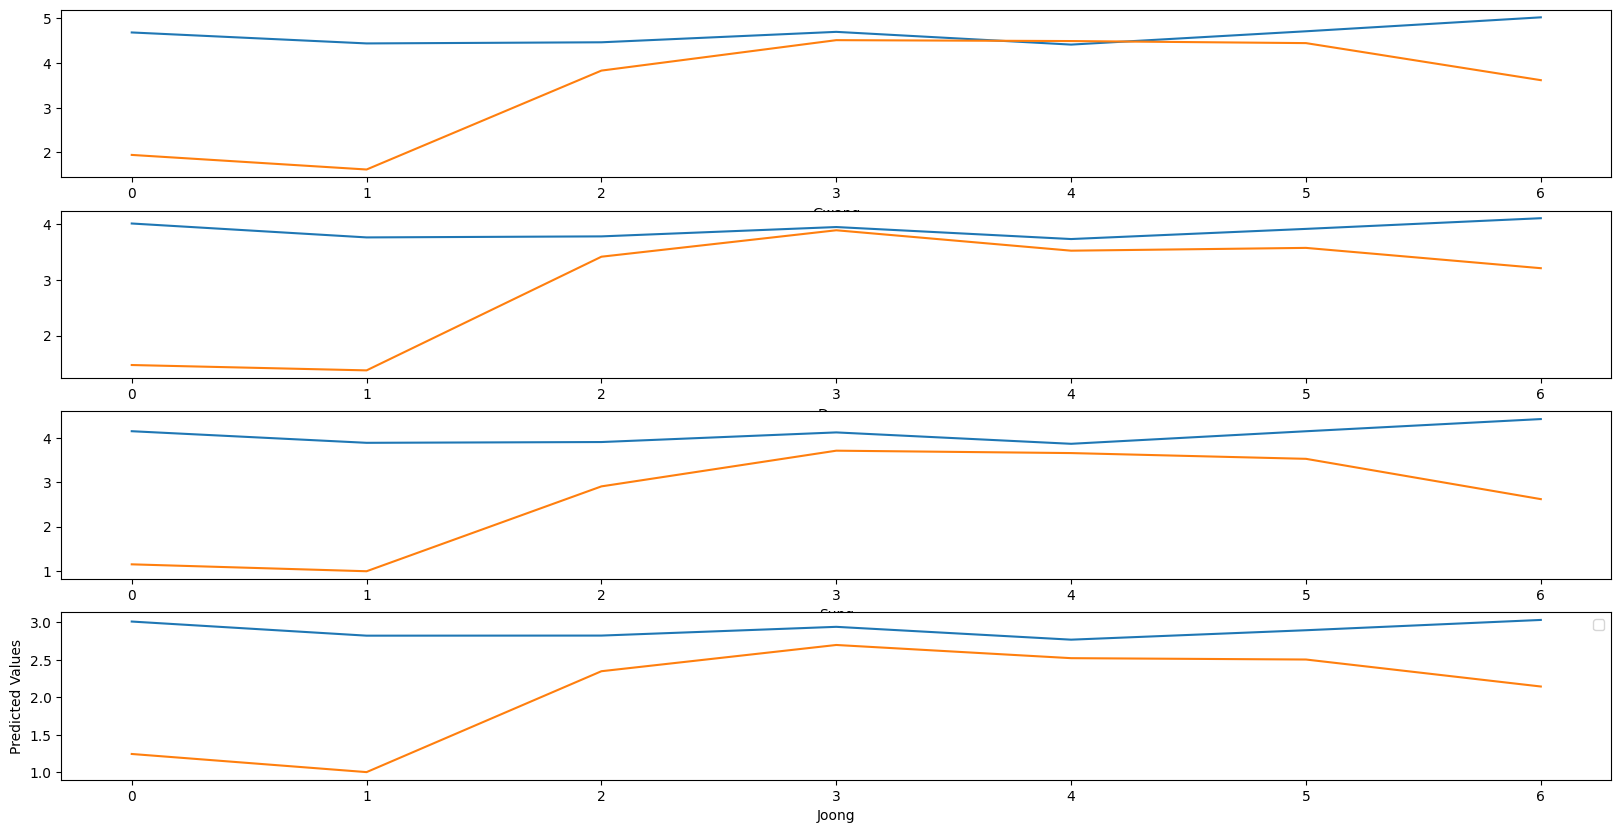

In [32]:
fig,axes = plt.subplots(4,1,figsize=(20,10))
axes[0].plot(future_predictions[:,0])
axes[0].plot(y_test[:,0])
axes[0].set_xlabel('Gwang')
axes[1].plot(future_predictions[:,1])
axes[1].plot(y_test[:,1])
axes[1].set_xlabel('Dong')
axes[2].plot(future_predictions[:,2])
axes[2].plot(y_test[:,2])
axes[2].set_xlabel('Sung')
axes[3].plot(future_predictions[:,3])
axes[3].plot(y_test[:,3])
axes[3].set_xlabel('Joong')
plt.ylabel('Predicted Values')
plt.legend()
plt.show()